In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import requests
sns.set()

## Pull sentiment and BTC/USDT data from bitcurate API.

Can read more about this API at https://doc.api.bitcurate.com/

In [2]:
r = requests.get('https://datascience.api.dev.bitcurate.com/social_sentiment?query=(BTC%20OR%20bitcoin)%20AND%20binance&before_date=7/28/2019%200:0')
sentiment = r.json()
sentiment.keys()

dict_keys(['momentum', 'sentiment', 'timestamp', 'volatility'])

In [3]:
r = requests.get('https://datascience.api.dev.bitcurate.com/pair?before_date=7/28/2019%200:0&pair=BTC/USDT&exchange=binance')
btc = r.json()
btc.keys()

dict_keys(['close', 'high', 'low', 'momentum', 'open', 'timestamp', 'volatility', 'volume'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


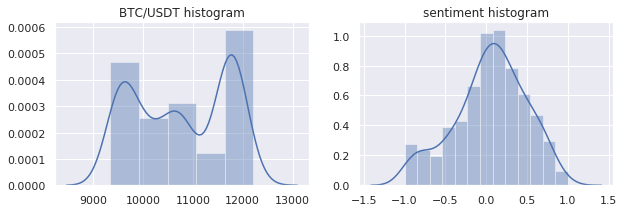

In [4]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.distplot(btc['close'])
plt.title('BTC/USDT histogram')
plt.subplot(1,2,2)
sns.distplot(sentiment['sentiment'])
plt.title('sentiment histogram')
plt.show()

In [5]:
df_sentiment = pd.DataFrame(sentiment)
df_btc = pd.DataFrame(btc)
merged = df_sentiment.merge(df_btc, on = 'timestamp')
merged.head()

,momentum_x,sentiment,timestamp,volatility_x,close,high,low,momentum_y,open,volatility_y,volume
0,54.100145,0.647979,2019-07-28 00:00:00,13.029871,9437.793876,10188.660156,9333.0,121.488191,10063.752860,0.005554,3.945665e+08
1,54.100145,0.735402,2019-07-28 01:00:00,13.029871,9465.703704,10128.525571,9333.0,121.488191,10114.418547,0.005554,3.572301e+08
2,54.100145,0.217188,2019-07-28 02:00:00,13.029871,9483.203125,10119.250000,9333.0,121.488191,10092.491420,0.005554,3.508137e+08
3,54.100145,0.925275,2019-07-28 03:00:00,13.029871,9479.787842,10118.924909,9333.0,121.488191,10104.733922,0.005554,3.488241e+08
4,54.100145,0.511795,2019-07-28 04:00:00,13.029871,9511.625543,10111.742839,9333.0,121.488191,10101.157733,0.005554,3.504369e+08


In [6]:
number_simulation = 100
predict_day = 30
v = merged[['sentiment', 'close']].pct_change(1).dropna().values
variance = np.abs(v.T.dot(v) / v.shape[0])
daily_vol = np.sqrt(variance)
avg_daily_ret = np.mean(v,axis=0)
daily_drift = avg_daily_ret - (variance / 2)
drift = daily_drift - 0.5 * daily_vol ** 2

results_sentiment = pd.DataFrame()
results_close = pd.DataFrame()

for i in tqdm(range(number_simulation)):
    prices = []
    prices.append(merged[['sentiment', 'close']].iloc[-1].values)
    for d in range(predict_day):
        shock = np.random.normal(size=(1,2)).dot(drift + daily_vol)
        price = prices[-1] * np.exp(shock)
        prices.append(price[0])
    prices = np.array(prices)
    results_sentiment[i] = prices[:,0]
    results_close[i] = prices[:,1]

100%|██████████| 100/100 [00:00<00:00, 627.99it/s]


In [7]:
number_simulation = 100
predict_day = 30

close = merged['close'].tolist()
returns = pd.DataFrame(close).pct_change()
last_price = close[-1]
results = pd.DataFrame()
avg_daily_ret = returns.mean()
variance = returns.var()
daily_vol = returns.std()
daily_drift = avg_daily_ret - (variance / 2)
drift = daily_drift - 0.5 * daily_vol ** 2

results = pd.DataFrame()

for i in tqdm(range(number_simulation)):
    prices = []
    prices.append(merged['close'].iloc[-1])
    for d in range(predict_day):
        shock = [drift + daily_vol * np.random.normal()]
        shock = np.mean(shock)
        price = prices[-1] * np.exp(shock)
        prices.append(price)
    results[i] = prices

100%|██████████| 100/100 [00:00<00:00, 101.47it/s]


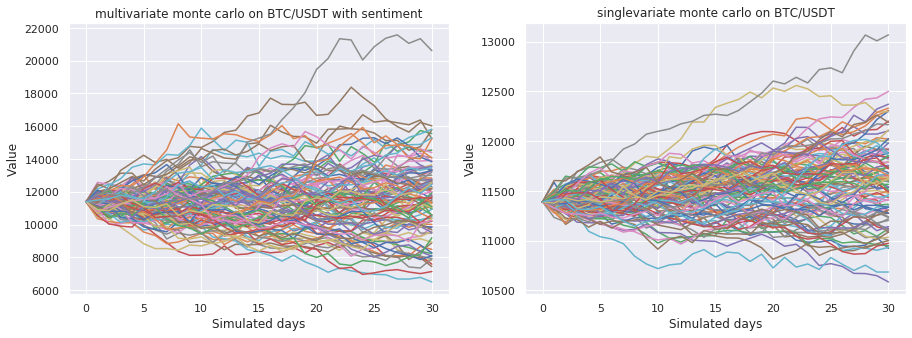

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(results_close)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.title('multivariate monte carlo on BTC/USDT with sentiment')
plt.subplot(1,2,2)
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.title('singlevariate monte carlo on BTC/USDT')
plt.show()

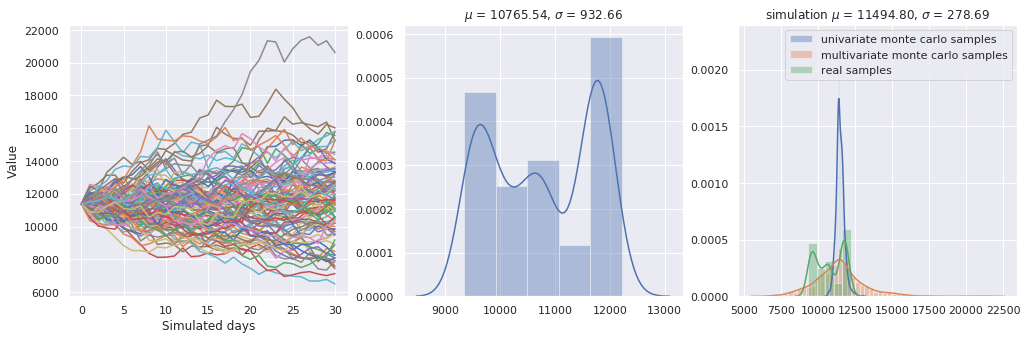

In [9]:
raveled = results.values.ravel()
raveled.sort()
cp_raveled = raveled.copy()

raveled_close = results_close.values.ravel()
raveled_close.sort()
cp_raveled_close = raveled_close.copy()

plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(results_close)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.subplot(1,3,2)
sns.distplot(close,norm_hist=True)
plt.title('$\mu$ = %.2f, $\sigma$ = %.2f'%(np.mean(close),np.std(close)))
plt.subplot(1,3,3)
sns.distplot(raveled,norm_hist=True,label='univariate monte carlo samples')
sns.distplot(raveled_close,norm_hist=True,label='multivariate monte carlo samples')
sns.distplot(close,norm_hist=True,label='real samples')
plt.title('simulation $\mu$ = %.2f, $\sigma$ = %.2f'%(raveled.mean(),raveled.std()))
plt.legend()
plt.show()